# Mask Object Detection Dataset Exploration

Within this notebook we'll briefly explore the datasets we curated for performing human mask object detection. 

Since the curated dataset(s) consists of several carefully chosen existing open-source datasets, we'll need to perform some analysis and perhaps cleaning to ensure the suitability and quality of our data prior to modelling.

---

- **Author**: Ben Fraser, https://github.com/BenjaminFraser
- **Date:** 24 Aug 2022


In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import PIL.Image as Image
import random
import skimage.color
import skimage.io
import xml.etree.ElementTree as ET

from matplotlib import rc
from matplotlib.lines import Line2D
from matplotlib.colors import rgb_to_hsv
from tqdm import tqdm

In [5]:
# get project path and set data directory for notebook
PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data/')

In [34]:
DATASET_NAME = "gdp_mask_dataset"
DATASET_NAME = "gdp_dataset_cleaned"

IMAGE_DIR = os.path.join(DATA_DIR, f'{DATASET_NAME}/Images')
ANNOTATIONS_DIR = os.path.join(DATA_DIR, f'{DATASET_NAME}/Annotations')
IMAGE_EXT = '.jpg'

In [35]:
image_files = [x for x in os.listdir(IMAGE_DIR) if x.endswith(IMAGE_EXT)]
annotation_files = [x for x in os.listdir(ANNOTATIONS_DIR) if x.endswith('.xml')]

print(f"Number of image files: {len(image_files)}")
print(f"Number of annotation files: {len(annotation_files)}")

Number of image files: 3650
Number of annotation files: 3650


## Validation of the images and associated bounding box labels

Let's create some helper functions to read our images and the associated labels. We'll then plot and visualise a range of random examples, to ensure our data is up to the required standard.

In [36]:
def read_xml_annotations(xml_filename: str, height_width_scaling=None):
    """ Parse our xml object detection bounding box annotations from
        file and return all classes with associated co-ords in
        [x_min, y_min, x_max, y_max] format. """

    tree = ET.parse(xml_filename)
    root = tree.getroot()
    
    # arrays to store class label and associated bbox coords
    classes = []
    bounding_boxes = []
    
    # iterate through all objects in file, gather class & bbox coords
    for boxes in root.iter('object'):

        filename = root.find('filename').text
        
        x_min, y_min, x_max, y_max = None, None, None, None

        # get class name and associated bbox coords
        class_name = boxes.find("name").text
        x_min = int(float(boxes.find("bndbox/xmin").text))
        y_min = int(float(boxes.find("bndbox/ymin").text))
        x_max = int(float(boxes.find("bndbox/xmax").text))
        y_max = int(float(boxes.find("bndbox/ymax").text))
        
        # add current class & bbox to our collection for this image
        bounding_boxes.append([x_min, y_min, x_max, y_max])
        classes.append(class_name)

    return filename, classes, bounding_boxes

In [37]:
def load_image(path, convert_rgba=True):
    """Load the specified image and return a [H,W,3] Numpy array."""
    # Load image
    image = skimage.io.imread(path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
        
    # if rgba - convert to rgb for consistency
    if convert_rgba and image.shape[2] == 4:
        image = skimage.color.rgba2rgb(image)
    return image

In [38]:
example_results = read_xml_annotations(os.path.join(ANNOTATIONS_DIR, 
                                                    os.listdir(ANNOTATIONS_DIR)[0]))

example_results

('MOXA_788.jpg',
 ['mask', 'nomask'],
 [[682, 29, 1055, 561], [257, 105, 470, 398]])

Lets also convert all of our labels into a DataFrame format, which will enable much easier analysis, fault-finding, and exploration of the wider dataset.

In [39]:
def make_labels_df_from_dir(img_dir, labels_dir, get_label_func, 
                            img_ext='.png', labels_ext='xml'):
    """ Combines all yolo formatted labels from a selected directory
        and places them into a dataframe. Must provide a get_label_func to
        precisely extract the labels from the annotations file """
    
    records = []
    labels_files = [x for x in os.listdir(labels_dir) 
                    if x.endswith(labels_ext) and x != 'classes.txt']
    
    # get annotation labels for all our images
    for label_file in labels_files:
        img_labels = get_label_func(label_file, 
                                    img_dir,
                                    labels_dir,
                                    img_ext)
        
        records.extend(img_labels)
        
    # create a final dataframe of results
    results_df = pd.DataFrame(records)   
    
    return results_df


def get_labels_from_xml_file(labels_filename, img_dir=IMAGE_DIR, 
                             labels_dir=ANNOTATIONS_DIR, img_ext='.png'):
    """ Combines bounding box labels for given image into a dataframe """ 

    base_name = labels_filename[:-4]
    img_path = os.path.join(img_dir, f"{base_name}{img_ext}")
    labels_path = os.path.join(labels_dir, labels_filename)

    # extract class names and bbox coords from current image
    _, class_labels, bbox_coords = read_xml_annotations(labels_path)

    # load image and get height and width
    try:
        img = load_image(img_path)
        img_height, img_width, _ = img.shape
    except FileNotFoundError:
        img_height, img_width = "No image found", "No image found"

    # create array to store labels
    records = []

    # gather all bounding boxes for given image
    for idx, class_name in enumerate(class_labels):
        
        # get bbox coords for current class_name object
        x_min, y_min, x_max, y_max = bbox_coords[idx]
        
        # form a dict with all our desired quantities
        record = {'filename' : f"{base_name}{img_ext}", 
                  'img_width' : img_width,
                  'img_height' : img_height, 
                  'object' : class_name,
                  'x_min' : x_min, 'y_min' : y_min, 
                  'x_max' : x_max, 'y_max' : y_max}
        records.append(record)
    return records

In [40]:
labels_df = make_labels_df_from_dir(img_dir=IMAGE_DIR, 
                                    labels_dir=ANNOTATIONS_DIR, 
                                    get_label_func=get_labels_from_xml_file,
                                    img_ext=IMAGE_EXT)

In [41]:
labels_df.head(5)

,filename,img_width,img_height,object,x_min,y_min,x_max,y_max
0,MOXA_788.jpg,1280,720,mask,682,29,1055,561
1,MOXA_788.jpg,1280,720,nomask,257,105,470,398
2,MOXA_950.jpg,299,168,mask,121,63,143,94
3,MOXA_950.jpg,299,168,mask,171,80,194,103
4,MOXA_1076.jpg,1280,720,mask,711,197,776,290


In [42]:
labels_df['object'].value_counts()

mask            7404
with-mask       3076
nomask          2338
without-mask    2314
unsure           684
with_mask        316
without_mask     142
0                 82
1                 81
2                 45
Name: object, dtype: int64

In [43]:
# make these class outputs consistent with our previous ones
correction_dict = {'mask' : 'with_mask',
                   'nomask' : 'without_mask',
                   'NM' : 'without_mask', 
                   'MW' : 'with_mask',
                   'with-mask' : 'with_mask',
                   'without-mask' : 'without_mask',
                   'unsure' : 'without_mask',
                   '0' : 'with_mask',
                   '1' : 'without_mask',
                   '2' : 'without_mask'}

labels_df['object'] = labels_df['object'].replace(correction_dict)

In [44]:
labels_df['object'].value_counts()

with_mask       10878
without_mask     5604
Name: object, dtype: int64

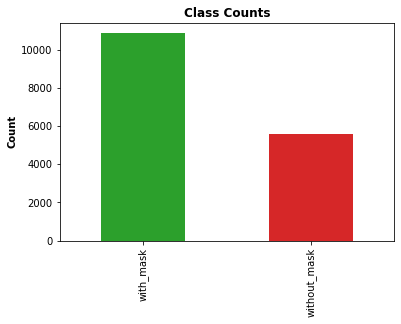

In [67]:
labels_df['object'].value_counts().plot.bar(color=["tab:green", "tab:red"])
plt.ylabel("Count", weight="bold")
plt.title("Class Counts", weight="bold")
plt.show()

We've got a good level of with_mask and without_mask examples, although as can be observed we do have a slight imbalance. Despite this, the imbalance is not too significant, and of course is something we can address through experimenting with data augmentation and class rebalancing strategries down the line if required.

In [45]:
# color map dictionary for different classes
color_map = {'with_mask' : [0.0, 255.0, 0.0],
             'without_mask' : [255.0, 0.0, 0.0]}

In [68]:
def draw_box(img, img_labels, color_map, t=2):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB. 
    t: Thickness of bounding box in pixels
    """
    # make a copy of the image to annotate
    annot_img = img.copy()

    # get x/y co-ords for all bboxes
    boxes = img_labels[['x_min', 'y_min', 'x_max', 'y_max']].values
    
    # get object labels for each bounding box
    object_labels = img_labels['object'].values
    
    # find number of boxes for given image
    num_boxes = boxes.shape[0]

    # convert bboxes to integers
    bboxes = boxes.astype(int)

    # iterate through all boxes and plot
    for i in range(num_boxes):
        # get co-ords for current bbox
        x_min, y_min, x_max, y_max = bboxes[i]
        
        # get associated color, subject to object type
        color = color_map[object_labels[i]]

        # plot bbox on image with desired thickness
        annot_img[y_min:y_min + t, x_min:x_max] = color
        annot_img[y_max:y_max + t, x_min:x_max] = color
        annot_img[y_min:y_max, x_min:x_min + t] = color
        annot_img[y_min:y_max, x_max:x_max + t] = color

    return annot_img, num_boxes


def plot_annotations(img_name, labels_df, data_dir=IMAGE_DIR, 
                     color_map=color_map, figsize=(12,10), legend=False):
    """ Helper function for plotting image & annotations """ 
    img = load_image(f"{data_dir}/{img_name}")
    img, num_boxes = draw_box(img, 
                        labels_df.loc[labels_df['filename'] == img_name],
                        color_map)
    
    plt.figure(figsize=figsize)
    plt.title(img_name, size=10)
    plt.imshow(img)
    plt.axis('off')
    
    # if legend chosen, annotate what class is which color
    if legend:
        # map color map colors to matplotlib style colors
        mpl_color_map = dict()
        for object_name in color_map.keys():
            mpl_color_map[object_name] = tuple([i/255 for i 
                                            in color_map[object_name]])
    
        # get object names and create legend lines for each class type
        object_ids = list(color_map.keys())
    
        legend_lines = [Line2D([0],[0], color=mpl_color_map[object_ids[i]], lw=2) 
                        for i in range(len(object_ids))]
        plt.legend(legend_lines, object_ids, loc='best')
        
    plt.show()
    print(f"\nNumber of annotations: {num_boxes}")
    return

In [54]:
random_images = np.random.choice(labels_df['filename'].unique(), size=10)

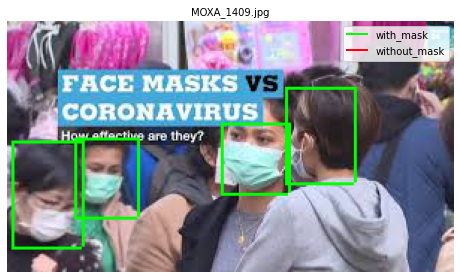


Number of annotations: 4


In [55]:
plot_annotations(random_images[0], labels_df, figsize=(8,6), legend=True)

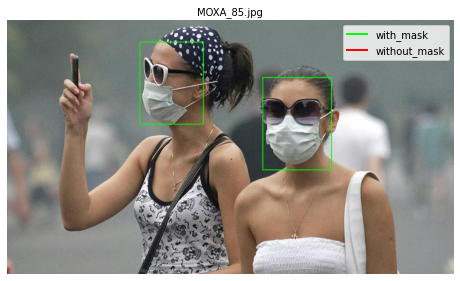


Number of annotations: 2


In [56]:
plot_annotations(random_images[1], labels_df, figsize=(8,6), legend=True)

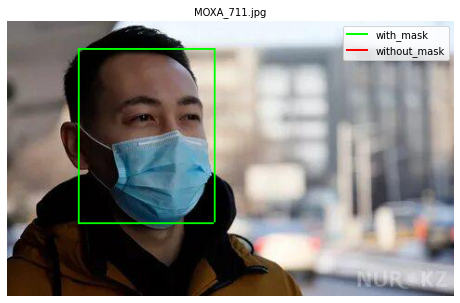


Number of annotations: 1


In [57]:
plot_annotations(random_images[2], labels_df, figsize=(8,6), legend=True)

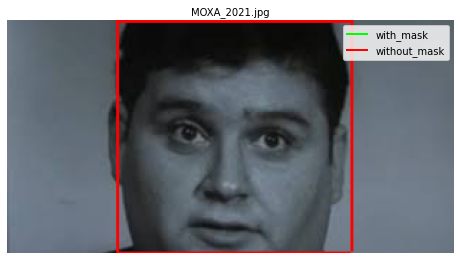


Number of annotations: 1


In [58]:
plot_annotations(random_images[4], labels_df, figsize=(8,6), legend=True)

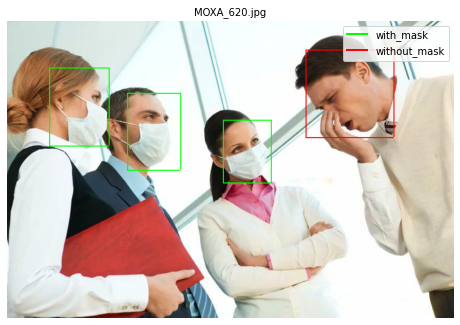


Number of annotations: 4


In [59]:
plot_annotations(random_images[5], labels_df, figsize=(8,6), legend=True)

Good - we definitely have a range of different types of scene, both simple and complex.